In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('SeoulBikeData.csv').drop(['Date', 'Holiday', 'Functioning Day', 'Seasons' ], axis = 1)
df.head()

,Bike_Count,Hour,Temperature(C),Humidity(%),Wind_speed,Visibility,Dew_point_temperature(C),Solar_Radiation,Rainfall(mm),Snowfall
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0


In [4]:
df = df[df['Hour'] == 12]
df = df.drop(['Hour'], axis = 1)

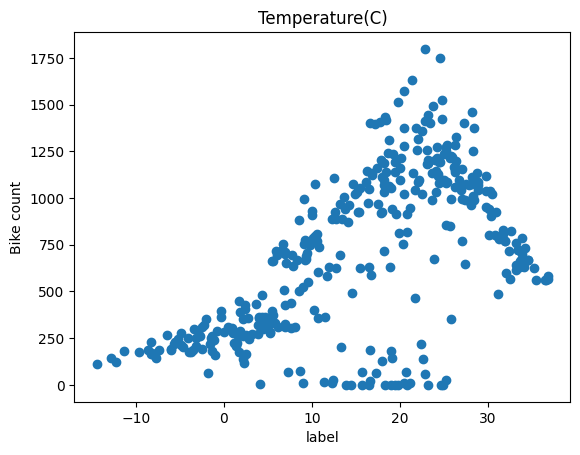

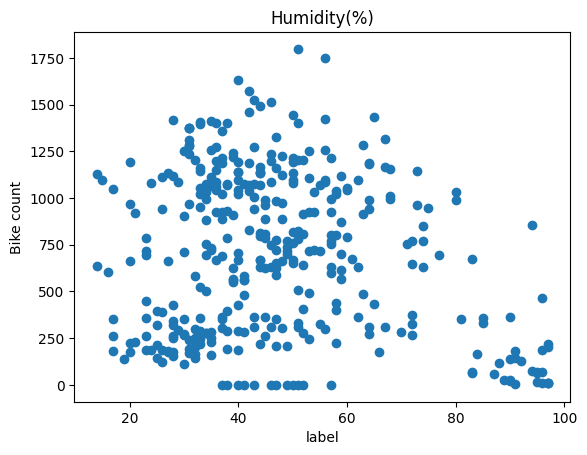

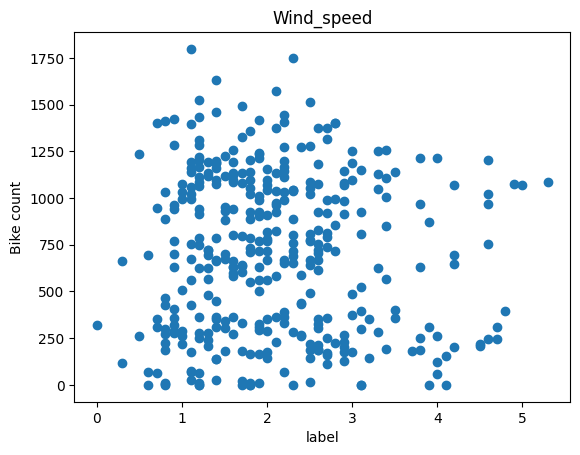

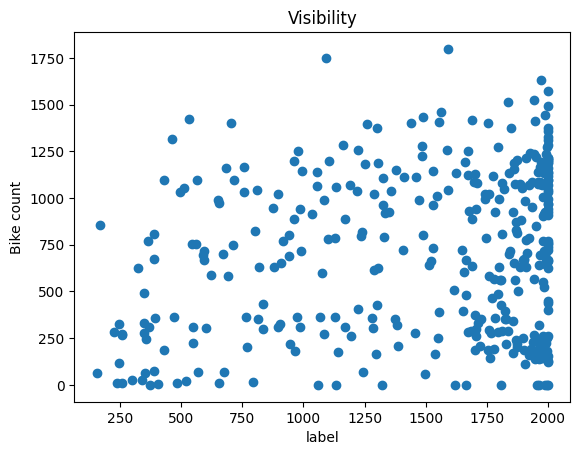

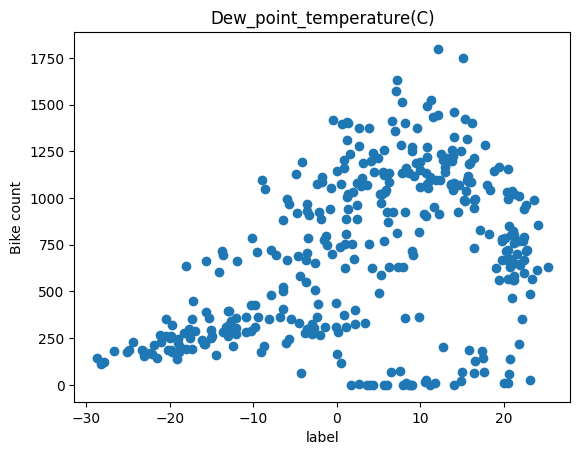

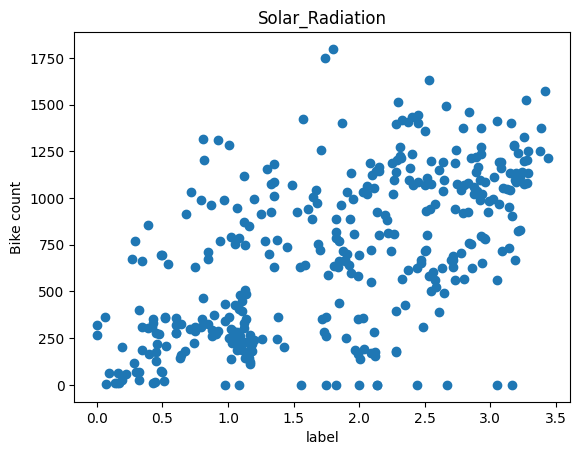

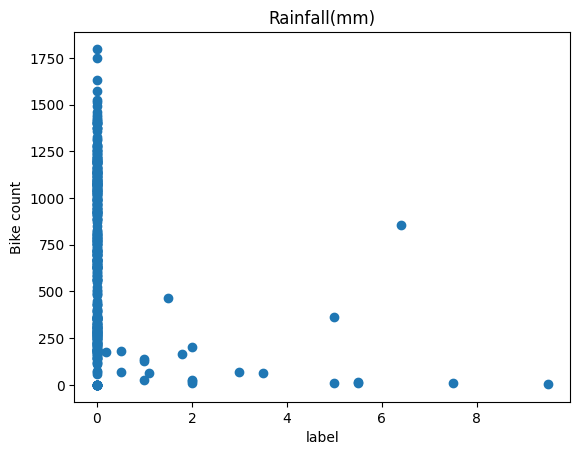

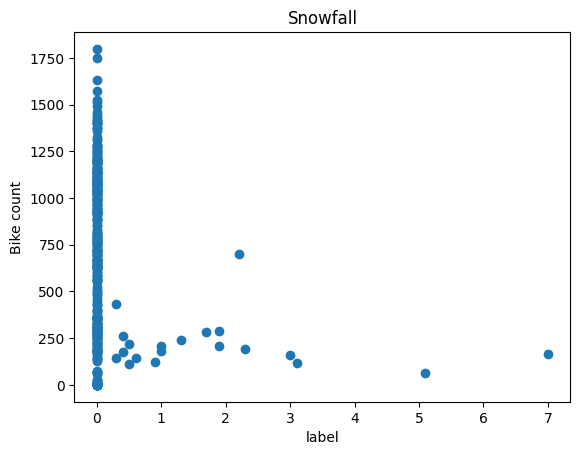

In [5]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["Bike_Count"])
  plt.title(label)
  plt.ylabel('Bike count')
  plt.xlabel('label')
  plt.show()

In [6]:
df = df.drop(['Wind_speed', 'Visibility'], axis = 1)

In [7]:
df.head()

,Bike_Count,Temperature(C),Humidity(%),Dew_point_temperature(C),Solar_Radiation,Rainfall(mm),Snowfall
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


In [8]:
train, val, test = np.split(df.sample(frac = 1), [int(0.6 * len(df)), int(0.8 * len(df))])

In [9]:
import copy

In [10]:
def get_xy(dataframe, y_label, x_labels = None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if len(x_labels) == 1:
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  return data, X, y


In [11]:
_, X_train_temp, y_train_temp = get_xy(train, "Bike_Count", x_labels = ["Temperature(C)"])
_, X_val_temp, y_val_temp = get_xy(val, "Bike_Count", x_labels = ["Temperature(C)"])
_, X_test_temp, y_test_temp = get_xy(test, "Bike_Count", x_labels = ["Temperature(C)"])

In [12]:
from sklearn.linear_model import LinearRegression
import tensorflow as tf

In [13]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

temp_reg.score(X_test_temp, y_test_temp)
# My score show me that there is some dependence but not so strong

0.2974655134346237

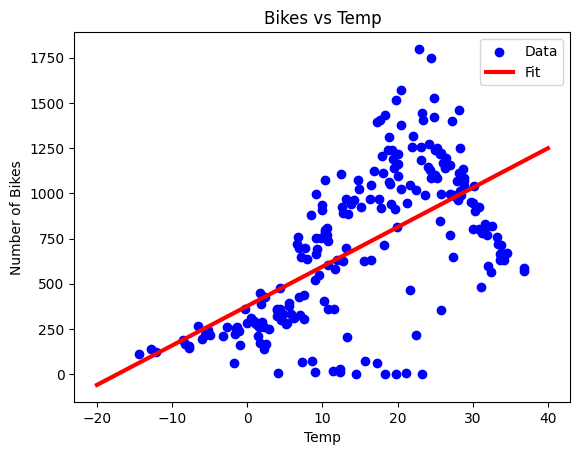

In [14]:
plt.scatter(X_train_temp, y_train_temp, label = "Data", color = "blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label = "Fit", color = "red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

In [16]:
train, val, test = np.split(df.sample(frac =1), [int(0.6 * len(df)), int(0.8 * len(df))])
_, X_train_all, y_train_all =  get_xy(train, 'Bike_Count', x_labels = df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, 'Bike_Count', x_labels = df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, 'Bike_Count', x_labels = df.columns[1:])

In [17]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

all_reg.score(X_test_all, y_test_all)

0.4365795034164953

In [23]:
def plot_loss(history):
  plt.plot(history.history['loss'], label = 'loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel("Epoch")
  plt.ylabel("MSE")
  plt.legend()
  plt.grid(True)
  plt.show()

In [24]:
temp_normalizer = tf.keras.layers.Normalization(input_shape = (1, ), axis = None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [25]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [29]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                      loss = 'mean_squared_error')

In [30]:
history = temp_nn_model.fit(X_train_temp.reshape(-1), y_train_temp,
                            verbose = 0,
                            epochs = 1000,
                            validation_data = (X_val_temp, y_val_temp))

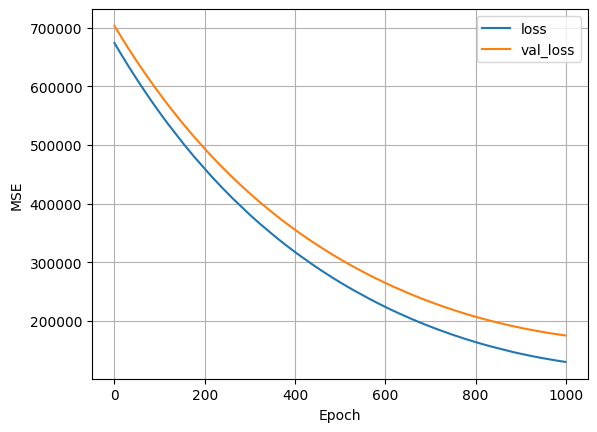

In [31]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


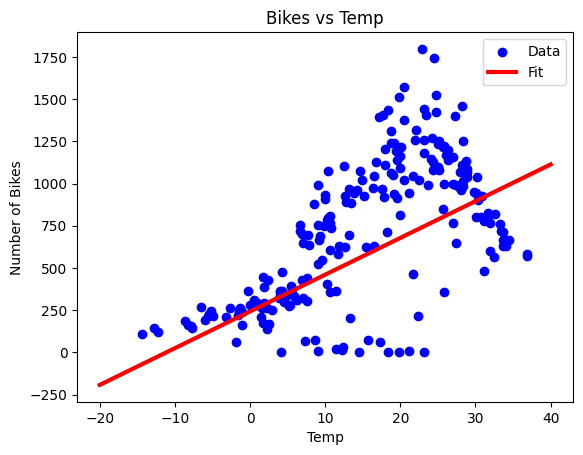

In [32]:
plt.scatter(X_train_temp, y_train_temp, label = 'Data', color = 'blue')
x = tf.linspace(-20, 40 ,100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label = 'Fit', color = 'red', linewidth = 3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

In [41]:
all_normalizer = tf.keras.layers.Normalization(input_shape = (6,), axis = 1)
all_normalizer.adapt(X_train_all)

In [44]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                 loss = 'mean_squared_error')

In [46]:
history = nn_model.fit(X_train_all, y_train_all,
             validation_data = (X_val_all, y_val_all),
             epochs = 100,
             verbose = 0)

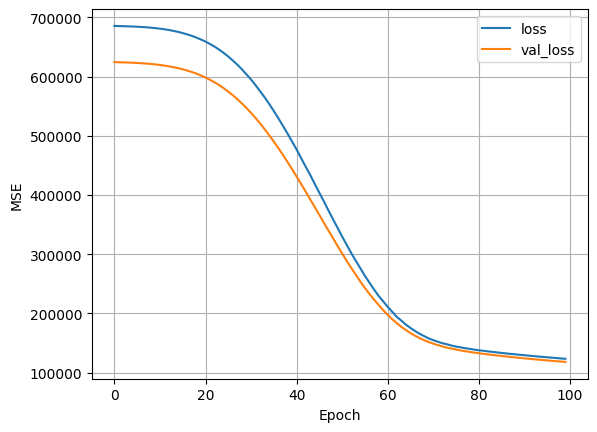

In [49]:
plot_loss(history)

In [50]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 [==============================] - 0s 6ms/step


In [51]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [52]:
MSE(y_pred_lr, y_test_all)

95986.52295996374

In [54]:
MSE(y_pred_nn, y_test_all)
# It looks that i have higher mse on neural net

124081.82289962746

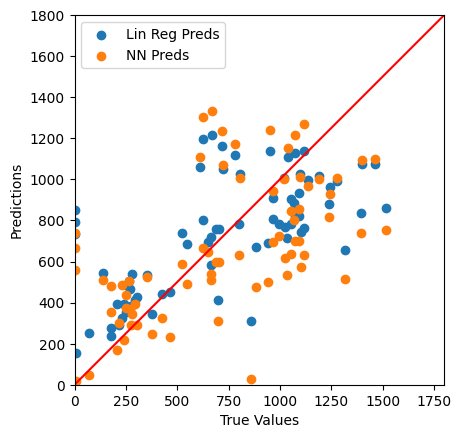

In [56]:
ax = plt.axes(aspect = 'equal')
plt.scatter(y_test_all, y_pred_lr, label = 'Lin Reg Preds')
plt.scatter(y_test_all, y_pred_nn, label = 'NN Preds')
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, color = 'red')